In [5]:
import matplotlib.pyplot as plt
import numpy as np
from code_ import savgol_filter, read_csv_multi
import seaborn as sns
from itertools import product
import os

In [7]:
def compute_snr(original, denoised):
    """
    Computes Signal-to-Noise Ratio (SNR) in decibels between original and denoised signals.
    Assumes original = signal + noise.
    """
    original = np.array(original)
    denoised = np.array(denoised)
    noise = original - denoised
    signal_power = np.mean(denoised ** 2)
    noise_power = np.mean(noise ** 2)
    if noise_power == 0:
        return np.inf
    return 10 * np.log10(signal_power / noise_power)

Running SNR grid search over multiple ECG files...

Window=3, PolyOrder=1 → Mean SNR = 24.01 dB
Window=3, PolyOrder=2 → Mean SNR = 313.22 dB
Window=5, PolyOrder=1 → Mean SNR = 18.76 dB
Window=5, PolyOrder=2 → Mean SNR = 27.94 dB
Window=5, PolyOrder=3 → Mean SNR = 27.94 dB
Window=5, PolyOrder=4 → Mean SNR = 294.73 dB
Window=7, PolyOrder=1 → Mean SNR = 15.69 dB
Window=7, PolyOrder=2 → Mean SNR = 23.32 dB
Window=7, PolyOrder=3 → Mean SNR = 23.32 dB
Window=7, PolyOrder=4 → Mean SNR = 29.70 dB
Window=7, PolyOrder=5 → Mean SNR = 29.70 dB
Window=7, PolyOrder=6 → Mean SNR = 284.17 dB
Window=9, PolyOrder=1 → Mean SNR = 13.28 dB
Window=9, PolyOrder=2 → Mean SNR = 21.03 dB
Window=9, PolyOrder=3 → Mean SNR = 21.03 dB
Window=9, PolyOrder=4 → Mean SNR = 25.24 dB
Window=9, PolyOrder=5 → Mean SNR = 25.24 dB
Window=9, PolyOrder=6 → Mean SNR = 30.85 dB
Window=9, PolyOrder=7 → Mean SNR = 30.85 dB
Window=9, PolyOrder=8 → Mean SNR = 244.66 dB
Window=11, PolyOrder=1 → Mean SNR = 11.27 dB
Window=11, PolyOrde

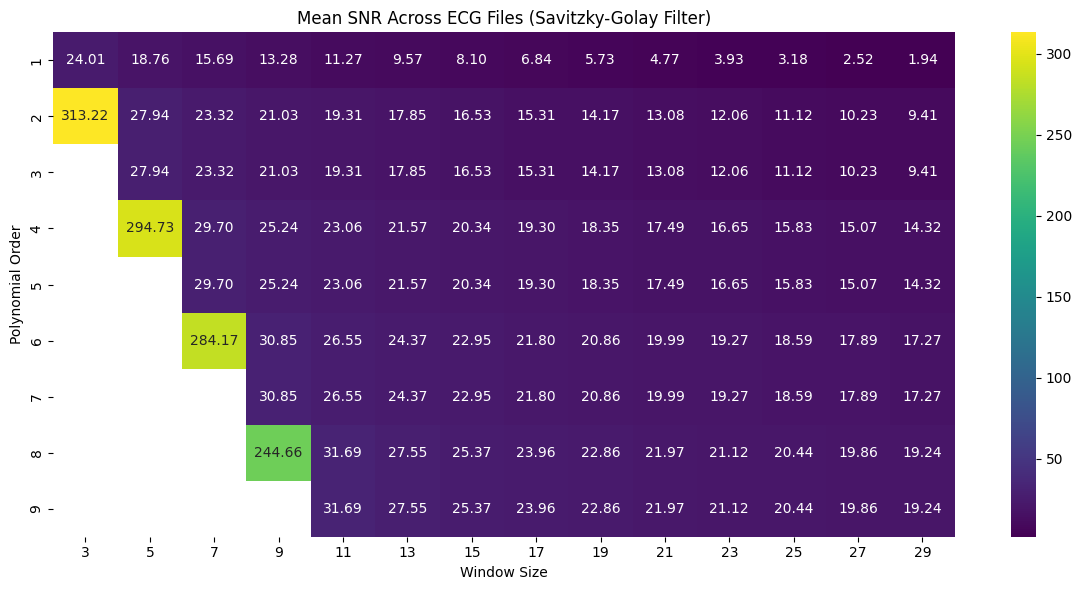

In [8]:
ecg_dir = "ECGData"
window_sizes = list(range(3, 31, 2))   
poly_orders = list(range(1, 10)) 
use_subset = True
max_files = 1000


all_files = [os.path.join(ecg_dir, f) for f in os.listdir(ecg_dir) if f.endswith('.csv')]
if use_subset:
    all_files = all_files[:max_files]

results = {}

print("Running SNR grid search over multiple ECG files...\n")

for w, p in product(window_sizes, poly_orders):
    if p >= w:
        continue
    file_snrs = []
    for filepath in all_files:
        try:
            channels = read_csv_multi(filepath)
            test_channels = [ch[:2000] for ch in channels[:3]] if use_subset else channels
            snrs = []
            for channel in test_channels:
                filtered = savgol_filter(channel, w, p)
                snr = compute_snr(channel, filtered)
                snrs.append(snr)
            file_snrs.append(np.mean(snrs))
        except Exception as e:
            print(f"Failed on {filepath}: {e}")
            continue
    if file_snrs:
        overall_mean_snr = np.mean(file_snrs)
        results[(w, p)] = overall_mean_snr
        print(f"Window={w}, PolyOrder={p} → Mean SNR = {overall_mean_snr:.2f} dB")


best_combo = max(results.items(), key=lambda x: x[1])
best_window, best_poly = best_combo[0]
best_snr = best_combo[1]
print(f"\nBest overall filter: window={best_window}, poly_order={best_poly}, mean SNR={best_snr:.2f} dB")


heatmap_matrix = np.full((len(poly_orders), len(window_sizes)), np.nan)
for i, p in enumerate(poly_orders):
    for j, w in enumerate(window_sizes):
        if (w, p) in results:
            heatmap_matrix[i, j] = results[(w, p)]

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_matrix, annot=True, fmt=".2f", cmap='viridis',
            xticklabels=window_sizes, yticklabels=poly_orders)
plt.title("Mean SNR Across ECG Files (Savitzky-Golay Filter)")
plt.xlabel("Window Size")
plt.ylabel("Polynomial Order")
plt.tight_layout()
plt.show()